In [25]:
#!pip3 install opencv-python
# this is a bug fix, on advice from mentor Ayush

# 1 Camera Calibration

In [26]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt

# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
#print(objp) yields
#[[ 0.  0.  0.]
# [ 1.  0.  0.]
# [ 2.  0.  0.]
# [ 3.  0.  0.]
# ...

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')
#print(type(images))  images is a pyton list

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'corners_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #plt.imshow(img) #cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



In [27]:
print(objpoints[3].shape)
print(imgpoints[3].shape)


(54, 3)
(54, 1, 2)


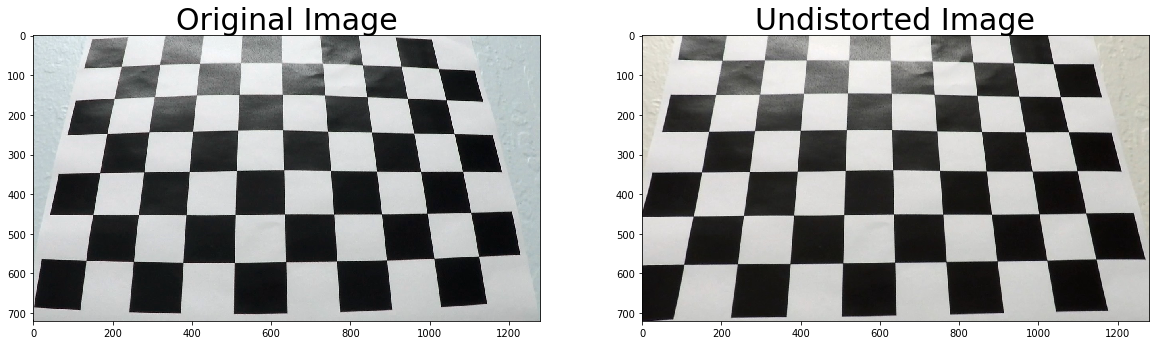

In [28]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/calibration3_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
#cv2.imwrite('./camera_cal/calibration3_compare.jpg',f)

# 2 Pipeline single images

## 2.1 Provide an example of a distortion-corrected image.

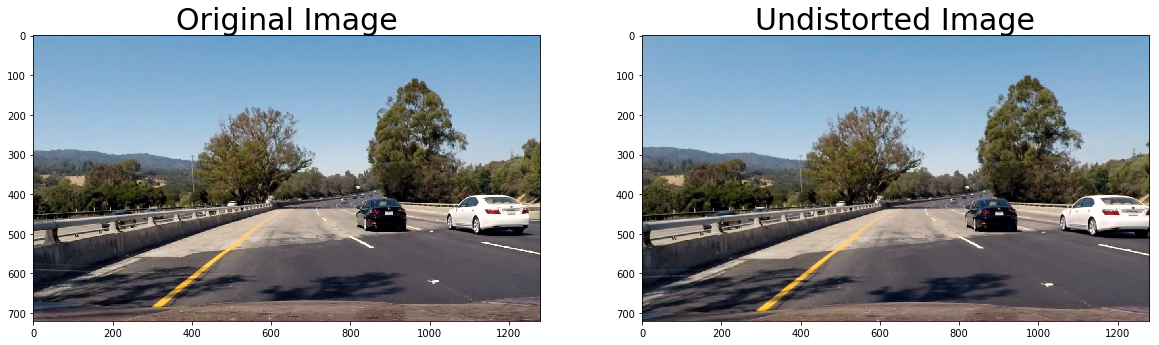

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

#reading in an image
#image = mpimg.imread('test_images/test1.jpg')
#image = mpimg.imread('test_images/test2.jpg')
#image = mpimg.imread('test_images/test3.jpg')
image = mpimg.imread('test_images/test4.jpg') # difficult one
#image = mpimg.imread('test_images/test5.jpg') # curvature uneven 
#image = mpimg.imread('test_images/test6.jpg')
#image = mpimg.imread('test_images/straight_lines1.jpg')
#image = mpimg.imread('test_images/straight_lines2.jpg')

original_image=image # for further reference for plotting things

dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#printing out some stats and plotting

image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
#cv2.imwrite('./test_images/test1_undist.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

## 2.2 Create thresholded binary image.

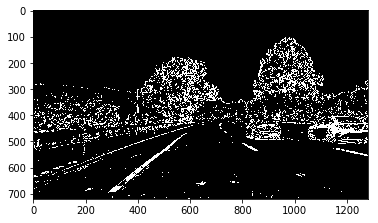

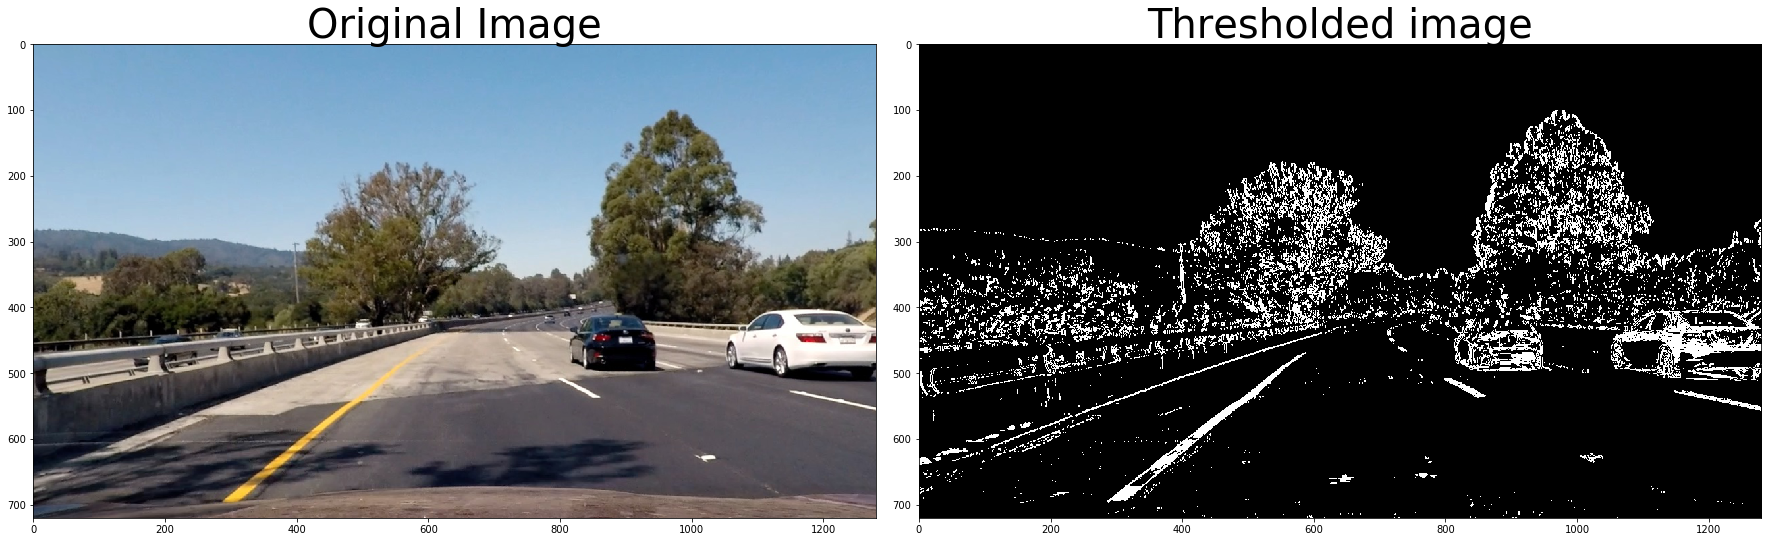

In [30]:
image = image_undistorted   # use undistorted image from last step in pipeline
original_image_undistorted=image_undistorted # for further reference for plotting things


# Edit this function to create your own pipeline.
def thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)): #s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
result, result_gray = thresholding(image)

plt.imshow(result_gray,cmap='gray')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

#ax2.set_title('Combined S channel and gradient thresholds')
#ax2.imshow(combined_binary, cmap='gray')

ax2.imshow(result_gray,cmap='gray')
ax2.set_title('Thresholded image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## 2.3 Apply perspective transform.

(720, 1280)


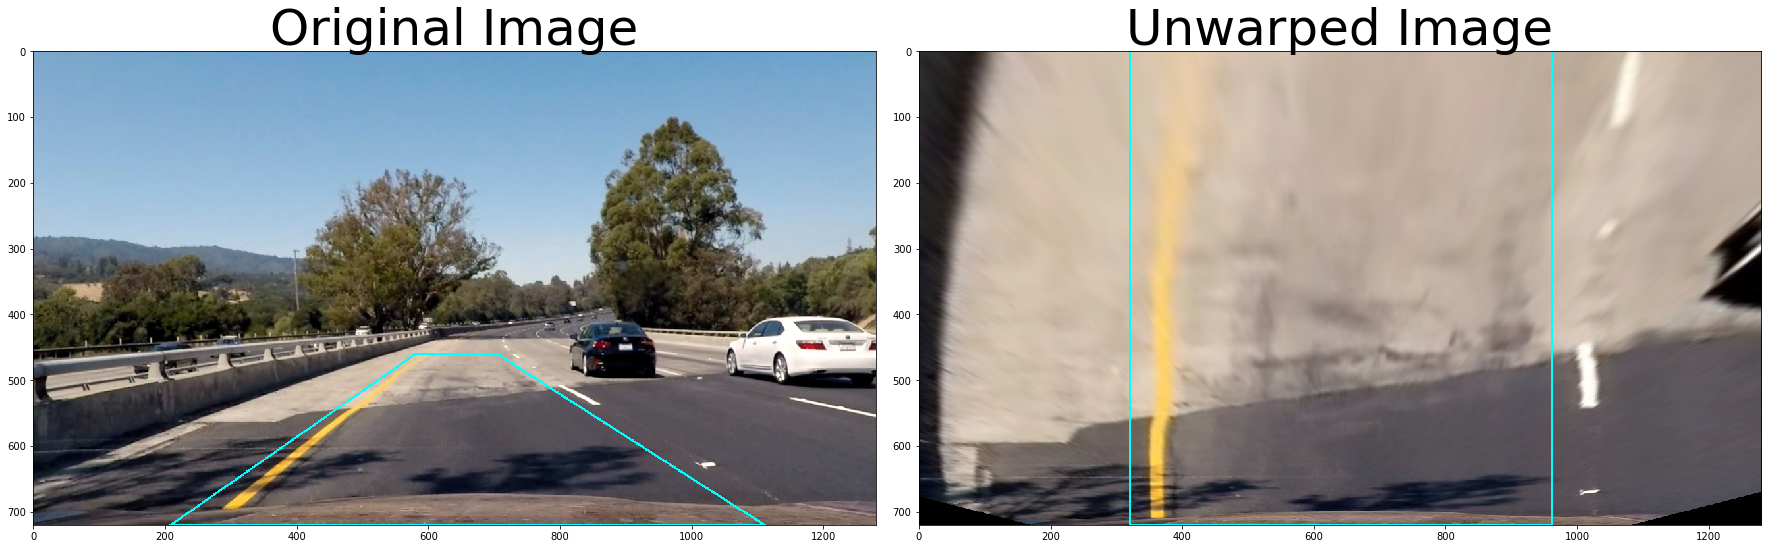

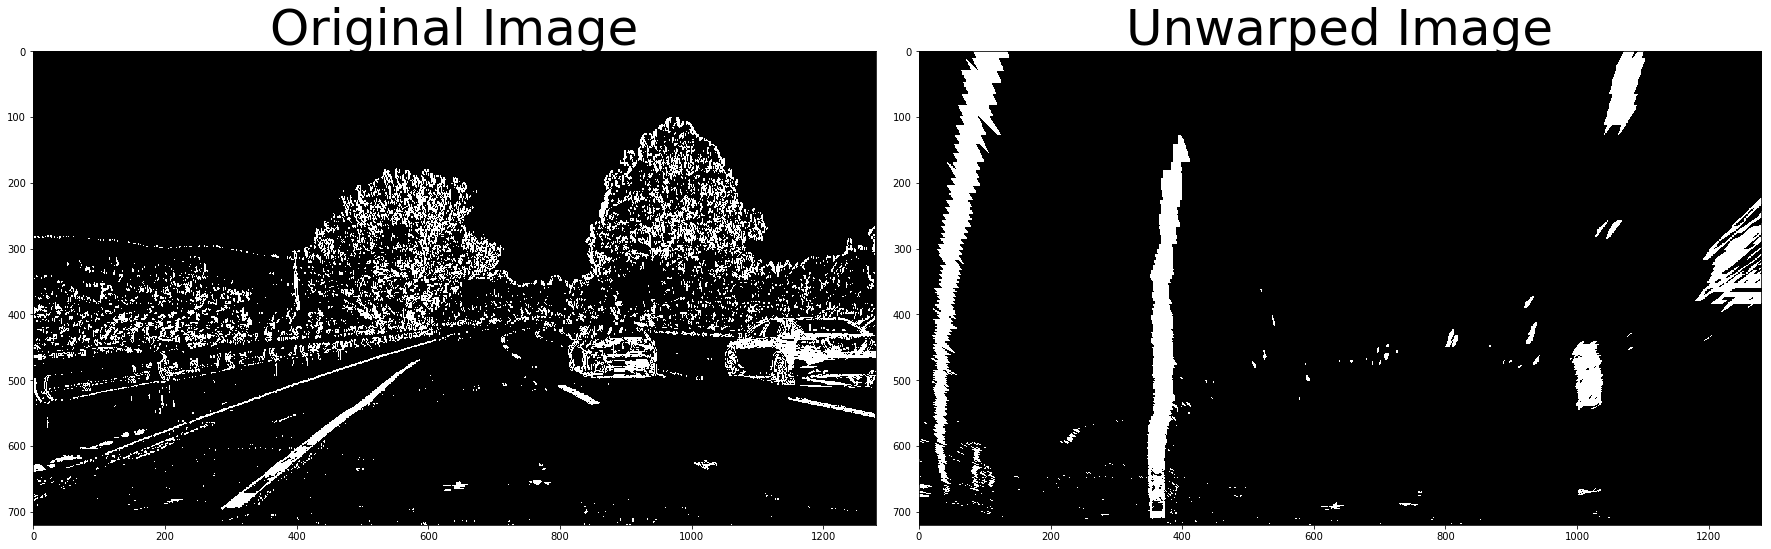

In [31]:
image = result_gray   # use undistorted and thresholded image from last step in pipeline
print(image.shape)


def unwarp(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32(
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - (5)), img_size[1]],
     [(img_size[0] * 5 / 6) + 45, img_size[1]],
     [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, src, dst
    
# the following is for the pipeline    
top_down_gray, perspective_M, src, dst = unwarp(result_gray)

#the remainder is only for plotting pictures for the writeup
top_down, perspective_M, src, dst = unwarp(original_image_undistorted)

src = src.reshape((-1,1,2))
orig_plus_polygon=cv2.polylines(original_image_undistorted,np.int32([src]),True,(0,255,255),2)
dst = dst.reshape((-1,1,2))
top_down_plus_polygon=cv2.polylines(top_down,np.int32([dst]),True,(0,255,255),2)

#print(perspective_M.shape)original_image_undistorted
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_plus_polygon)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_plus_polygon)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#print(perspective_M.shape)original_image_undistorted
#print(top_down.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result_gray,cmap='gray')
#ax1.imshow(image,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down_gray,cmap='gray')
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 2.4 Fit lines with polynomial.

In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line valid, i.e. self-consistent in the last iteration?
        self.valid = False  
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = np.zeros(720,dtype='int32')     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 100.0
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = np.zeros(720,dtype='float')   
        #y values for detected line pixels
        self.ally = np.zeros(720,dtype='float')     

In [33]:
lLine=Line()
rLine=Line()

not both lines valid!
computing from scratch


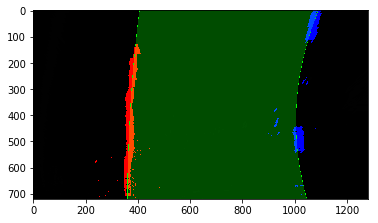

In [34]:


binary_warped = top_down_gray  #use image from last step in pipeline
#print(binary_warped.shape)



def find_lane_pixels_from_scratch(binary_warped):
    print("computing from scratch")
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    # Create an output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 125  # increased from 100 (classroom quiz)
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ###  Find the four below boundaries of the window ###
        win_xleft_low = leftx_current- margin
        win_xleft_high = leftx_current+ margin   
        win_xright_low = rightx_current- margin   
        win_xright_high = rightx_current+ margin  
        
        # optional: Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ###  Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                          &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if good_left_inds.size > minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if good_right_inds.size > minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
   
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def find_lane_pixels_using_prev(binary_warped):
    
    #print("using prior values!")
    
    left_fit = lLine.best_fit
    right_fit = rLine.best_fit
    
    def fit_poly(img_shape, leftx, lefty, rightx, righty):
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx,2)
        right_fit = np.polyfit(righty, rightx,2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        return left_fitx, right_fitx, ploty
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    #ploty_ = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx_ = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx_ = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    win_xleft_low = left_fitx_ - margin 
    win_xleft_high = left_fitx_+ margin  
    win_xright_low = right_fitx_ - margin   
    win_xright_high = right_fitx_ + margin  
    left_lane_inds =  ((nonzerox > win_xleft_low)  & (nonzerox < win_xleft_high)).nonzero()[0]
    right_lane_inds = ((nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)


    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
    #result = search_around_poly(binary_warped)
    return np.int32(left_fitx), np.int32(ploty) , np.int32(right_fitx), np.int32(ploty) #leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    if not (lLine.valid and rLine.valid):
        print("not both lines valid!")
        leftx, lefty, rightx, righty = find_lane_pixels_from_scratch(binary_warped)
    else: 
        leftx, lefty, rightx, righty = find_lane_pixels_using_prev(binary_warped)
        
        

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx,2)
    #print(left_fit)
    right_fit = np.polyfit(righty, rightx,2)
    #print(right_fit)

                                
    
    # Generate x and y values for plotting
    ploty = np.int32(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )) 
    left_fitx = np.int32(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
    left_fitx = np.minimum(left_fitx, 1279) 
    left_fitx = np.maximum(left_fitx, 0) 
    right_fitx = np.int32(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
    right_fitx = np.minimum(right_fitx, 1279) 
    right_fitx = np.maximum(right_fitx, 0) 
    
    
    
        
   
   
    
    ## Visualization ## plot last valid value!
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
    # Colors in the left and right lane regions
    
    # using previously stored, valid values!
    left_fitxv = np.int32(lLine.allx)#left_fitx # np.int32(lLine.allx)
    left_fitxv = np.minimum(left_fitx, 1279) 
    left_fitxv = np.maximum(left_fitx, 0) 
    right_fitxv = np.int32(rLine.allx) #right_fitx #np.int32(rLine.allx)
    right_fitxv = np.minimum(right_fitx, 1279) 
    right_fitxv = np.maximum(right_fitx, 0) 
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img[ploty, left_fitxv] = [0, 255, 0]
    out_img[ploty, right_fitxv] = [0, 255, 0]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow',linewidth=4.0)
    #plt.plot(right_fitx, ploty, color='yellow',linewidth=4.0)
    
    
    # Draw the lane onto the  image
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped)) *255
    window_img = np.zeros_like(out_img)
    
    margin=np.int32(10)
    
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
    #                          ploty])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
    #                          ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))
    #cv2.fillPoly(window_img, np.int32([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int32([right_line_pts]), (0,255, 0))
    
    green_stripe_window1 = np.array([np.transpose(np.vstack([left_fitxv, ploty]))])
    green_stripe_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitxv, 
                              ploty])))])
    green_stripe_pts = np.hstack((green_stripe_window1, green_stripe_window2))
    cv2.fillPoly(window_img, np.int32([green_stripe_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result,ploty,left_fitx,right_fitx ,left_fit,right_fit


out_img, ploty,left_fitx,right_fitx, left_fit,right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)


## 2.5 Compute curvature and offset in metres.

In [35]:
def plausibility_check(ploty_cr, left_fitx_cr, right_fitx_cr,left_curverad, right_curverad, offset_x_m):
    
    mindistance= np.min(right_fitx_cr- left_fitx_cr) # at least 3m typ. value: 3.35317400005
    #print(mindistance)
    maxdistance=np.max((right_fitx_cr- left_fitx_cr)) # no more than 4m typ. value: 3.61941697379
    #print(maxdistance)
    distance_ok= (mindistance > 2.9) and (maxdistance <3.6)
    #print(distance_ok)
    isplausible_left=distance_ok   # to be implented. Are the new values any good?
    if isplausible_left:  # if yes update lLine / rLine 
        lLine.valid=True
        lLine.radius_of_curvature= 1/(1/lLine.radius_of_curvature*0.975+ 1/left_curverad*0.025)
        lLine.best_fit=left_fit
        lLine.allx = np.int32(left_fitx_cr/(3.7/700))
        lLine.ally = np.int32(ploty_cr/(30/720 ))
    else: # otherwise keep old values and mark invalid
        lLine.valid=False
        
    isplausible_right=distance_ok # to be implented. Are the new values any good?
    if isplausible_right:  # if yes update lLine / rLine 
        rLine.valid=True
        rLine.radius_of_curvature= 1/(1/rLine.radius_of_curvature*0.975+ 1/right_curverad*0.025)
        rLine.best_fit=right_fit
        rLine.allx = np.int32(right_fitx_cr/(3.7/700))
        rLine.ally = np.int32(ploty_cr/(30/720 ))
    else: # otherwise keep old values and mark invalid
        rLine.valid=False
    #print(isplausible_left and isplausible_right)
    return isplausible_left, isplausible_right 


def convert_to_metres(ploty, left_fit,right_fit , ym_per_pix, xm_per_pix):
    '''
    converts/rescales all coefficients etc. to metres
    '''
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    #leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
    #                                for y in ploty])
    #rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
    #                                for y in ploty])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty*ym_per_pix, rightx*xm_per_pix, leftx*xm_per_pix,left_fit_cr, right_fit_cr

    
def measure_curvature_and_offset_real(ploty, left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty_cr, rightx_cr, leftx_cr, left_fitx_cr, right_fitx_cr = convert_to_metres(ploty, 
                    left_fit,right_fit,ym_per_pix, xm_per_pix)
    #return ploty*ym_per_pix, rightx*xm_per_pix, leftx*xm_per_pix,left_fit_cr, right_fit_cr
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty_cr)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    A=left_fitx_cr[0]
    B=left_fitx_cr[1]
    left_curverad = 1/(2*A)* (1+(2*A*y_eval+B)**2)**(3/2) 
    A=right_fitx_cr[0]
    B=right_fitx_cr[1]
    right_curverad = 1/(2*A)* (1+(2*A*y_eval+B)**2)**(3/2)   
    #compute offset 
    leftx_bot = left_fitx_cr[0]*y_eval**2 + left_fitx_cr[1]*y_eval + left_fitx_cr[2]
    rightx_bot = right_fitx_cr[0]*y_eval**2 + right_fitx_cr[1]*y_eval + right_fitx_cr[2]
    avx_bot=1/2*(leftx_bot +rightx_bot)
    offset_x_m= 1280/2*xm_per_pix -avx_bot
    
    plausibility_check(ploty_cr, leftx_cr, rightx_cr,left_curverad, right_curverad, offset_x_m)
    
    return left_curverad, right_curverad,offset_x_m


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset_x_m = measure_curvature_and_offset_real(ploty, left_fit,right_fit )




print(left_curverad, 'm', right_curverad, 'm', offset_x_m, 'm')


1838.0703132752462 m 342.2286876648366 m -0.5778764360455928 m


## 2.6 Projecting back to the road.

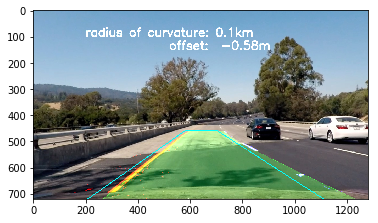

In [36]:
def warp_again(img):
    img_size=(img.shape[1],img.shape[0])
    src = np.float32(
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - (5)), img_size[1]],
     [(img_size[0] * 5 / 6) + 45, img_size[1]],
     [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
    dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
    # use cv2.geimage_undistortedtPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform( dst,src) # other way round!!
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, src, dst
def project_back(img,left_curverad, right_curverad,offset_x_m):
    warped_again, M, src, dst = warp_again(img)
    #finalpic = cv2.addWeighted(image_undistorted, 1, warped_again, 0.9, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    curverad=1/2*(right_curverad+left_curverad)
    string1= 'radius of curvature: '+str(round(curverad/1000,2))+'km'
    string2='offset:  '+str(round(offset_x_m,2))+'m'
    cv2.putText(warped_again,string1,(200,100), font, 1.5,(255,255,255),4,cv2.LINE_AA)
    cv2.putText(warped_again,string2,(520,150), font, 1.5,(255,255,255),4,cv2.LINE_AA)
    return warped_again
left_curverad_av=lLine.radius_of_curvature
right_curverad_av=rLine.radius_of_curvature
warped_again=project_back(out_img,left_curverad_av, right_curverad_av,offset_x_m )

finalpic = cv2.addWeighted(image_undistorted, 1, warped_again, 0.9, 0)
plt.imshow(finalpic)

# 3 Pipeline video

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [38]:
print(lLine.valid)
print(rLine.valid)

False
False


In [39]:
lLine=Line()
rLine=Line()


In [40]:


#def new_detection_is_valid()

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    ##global prev_line_image
    ##assert(prev_line_image.shape==(720, 1280, 3) )
    
    #nonlocal lLine
    #lLine.detected = True
    
    #2.1
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    #2.2
    result, result_gray = thresholding(image_undistorted)
    
    #2.3

    top_down_gray, perspective_M, src, dst = unwarp(result_gray)
    
    #2.4
    out_img, ploty,left_fitx,right_fitx, left_fit,right_fit = fit_polynomial(top_down_gray)
    
    
    #2.5
    left_curverad, right_curverad, offset_x_m = measure_curvature_and_offset_real(ploty, left_fit,right_fit )
    # note that a plausibiliy check is performed inside this functions and the "memory"-objects lLine and rLine
    #are updated accordingly

    
    #2.6
    #warped_again=project_back(out_img,left_curverad, right_curverad,offset_x_m )
    left_curverad_av=lLine.radius_of_curvature
    right_curverad_av=rLine.radius_of_curvature
    warped_again=project_back(out_img,left_curverad_av, right_curverad_av,offset_x_m )

    finalpic = cv2.addWeighted(image_undistorted, 1, warped_again, 0.9, 0)
    
    
    #  lines_edges = weighted_img( masked_line_image,image)   
    #out_image_gray= result_gray
    #out_img = np.dstack((out_image_gray, out_image_gray, out_image_gray))
    return finalpic#out_img #image

In [41]:
lLine=Line() # initialize!
rLine=Line() 
prev_line_image=np.zeros((540, 960, 3), dtype=np.uint8)
output_video_name = 'output_project_video.mp4'
input_clip = VideoFileClip("project_video.mp4")#.subclip(0,5)
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

not both lines valid!
computing from scratch
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



 15%|█▍        | 188/1261 [00:12<01:13, 14.58it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 15%|█▌        | 190/1261 [00:13<01:13, 14.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 15%|█▌        | 194/1261 [00:13<01:13, 14.55it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 16%|█▌        | 196/1261 [00:13<01:13, 14.54it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 18%|█▊        | 228/1261 [00:15<01:11, 14.50it/s]

not both lines valid!
computing from scratch



 18%|█▊        | 232/1261 [00:16<01:11, 14.48it/s]

not both lines valid!
computing from scratch



 19%|█▉        | 242/1261 [00:16<01:10, 14.46it/s]

not both lines valid!
computing from scratch



 22%|██▏       | 274/1261 [00:18<01:08, 14.44it/s]

not both lines valid!
computing from scratch



 43%|████▎     | 546/1261 [00:38<00:50, 14.21it/s]

not both lines valid!
computing from scratch



 44%|████▍     | 552/1261 [00:38<00:49, 14.21it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 44%|████▍     | 554/1261 [00:38<00:49, 14.21it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 44%|████▍     | 558/1261 [00:39<00:49, 14.20it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 44%|████▍     | 560/1261 [00:39<00:49, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 45%|████▍     | 564/1261 [00:39<00:49, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 45%|████▌     | 568/1261 [00:40<00:48, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 46%|████▌     | 574/1261 [00:40<00:48, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 46%|████▌     | 576/1261 [00:40<00:48, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 46%|████▌     | 580/1261 [00:41<00:48, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 46%|████▌     | 582/1261 [00:41<00:48, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 46%|████▋     | 586/1261 [00:41<00:47, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 47%|████▋     | 588/1261 [00:41<00:47, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 47%|████▋     | 592/1261 [00:41<00:47, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 47%|████▋     | 594/1261 [00:42<00:47, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 47%|████▋     | 598/1261 [00:42<00:46, 14.11it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 48%|████▊     | 600/1261 [00:42<00:46, 14.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 48%|████▊     | 604/1261 [00:42<00:46, 14.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 48%|████▊     | 606/1261 [00:42<00:46, 14.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 48%|████▊     | 610/1261 [00:43<00:46, 14.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 49%|████▊     | 612/1261 [00:43<00:46, 14.09it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 49%|████▉     | 616/1261 [00:43<00:45, 14.09it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 49%|████▉     | 618/1261 [00:43<00:45, 14.08it/s]

not both lines valid!
computing from scratch



 50%|████▉     | 630/1261 [00:44<00:44, 14.07it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 50%|█████     | 634/1261 [00:45<00:44, 14.06it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 51%|█████     | 640/1261 [00:45<00:44, 14.05it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 68%|██████▊   | 858/1261 [01:01<00:28, 14.04it/s]

not both lines valid!
computing from scratch



 68%|██████▊   | 862/1261 [01:01<00:28, 14.04it/s]

not both lines valid!
computing from scratch



 69%|██████▊   | 866/1261 [01:01<00:28, 14.05it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 69%|██████▉   | 870/1261 [01:01<00:27, 14.05it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 69%|██████▉   | 872/1261 [01:02<00:27, 14.05it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 69%|██████▉   | 876/1261 [01:02<00:27, 14.05it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 70%|██████▉   | 880/1261 [01:02<00:27, 14.04it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 70%|██████▉   | 882/1261 [01:02<00:26, 14.04it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 70%|███████   | 886/1261 [01:03<00:26, 14.04it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 71%|███████   | 894/1261 [01:03<00:26, 14.04it/s]

not both lines valid!
computing from scratch



 72%|███████▏  | 906/1261 [01:04<00:25, 14.03it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 72%|███████▏  | 910/1261 [01:04<00:25, 14.02it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 72%|███████▏  | 914/1261 [01:05<00:24, 14.01it/s]

not both lines valid!
computing from scratch



 73%|███████▎  | 920/1261 [01:05<00:24, 14.00it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 76%|███████▌  | 954/1261 [01:08<00:22, 13.95it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 79%|███████▊  | 990/1261 [01:11<00:19, 13.92it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 79%|███████▊  | 992/1261 [01:11<00:19, 13.92it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 79%|███████▉  | 996/1261 [01:11<00:19, 13.92it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 80%|███████▉  | 1004/1261 [01:12<00:18, 13.91it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 80%|███████▉  | 1006/1261 [01:12<00:18, 13.89it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 80%|████████  | 1012/1261 [01:12<00:17, 13.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 81%|████████  | 1016/1261 [01:13<00:17, 13.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 81%|████████  | 1018/1261 [01:13<00:17, 13.87it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 81%|████████  | 1022/1261 [01:13<00:17, 13.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 81%|████████  | 1024/1261 [01:13<00:17, 13.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 82%|████████▏ | 1028/1261 [01:14<00:16, 13.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 82%|████████▏ | 1030/1261 [01:14<00:16, 13.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 82%|████████▏ | 1032/1261 [01:14<00:16, 13.84it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 82%|████████▏ | 1036/1261 [01:14<00:16, 13.83it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 82%|████████▏ | 1038/1261 [01:15<00:16, 13.83it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 83%|████████▎ | 1042/1261 [01:15<00:15, 13.82it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 83%|████████▎ | 1046/1261 [01:15<00:15, 13.81it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 83%|████████▎ | 1050/1261 [01:16<00:15, 13.80it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 83%|████████▎ | 1052/1261 [01:16<00:15, 13.79it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 84%|████████▍ | 1058/1261 [01:16<00:14, 13.78it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 84%|████████▍ | 1064/1261 [01:17<00:14, 13.77it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 85%|████████▍ | 1070/1261 [01:17<00:13, 13.76it/s]

not both lines valid!
computing from scratch



 86%|████████▌ | 1084/1261 [01:18<00:12, 13.72it/s]

not both lines valid!
computing from scratch



 86%|████████▋ | 1088/1261 [01:19<00:12, 13.71it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 88%|████████▊ | 1104/1261 [01:20<00:11, 13.69it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 89%|████████▉ | 1124/1261 [01:22<00:10, 13.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 89%|████████▉ | 1126/1261 [01:22<00:09, 13.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 90%|████████▉ | 1130/1261 [01:22<00:09, 13.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 92%|█████████▏| 1156/1261 [01:24<00:07, 13.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 92%|█████████▏| 1160/1261 [01:24<00:07, 13.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 92%|█████████▏| 1162/1261 [01:24<00:07, 13.68it/s]

not both lines valid!
computing from scratch



 93%|█████████▎| 1170/1261 [01:25<00:06, 13.68it/s]

not both lines valid!
computing from scratch



 95%|█████████▍| 1192/1261 [01:27<00:05, 13.67it/s]

not both lines valid!
computing from scratch



 95%|█████████▌| 1202/1261 [01:27<00:04, 13.67it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 95%|█████████▌| 1204/1261 [01:28<00:04, 13.67it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 98%|█████████▊| 1230/1261 [01:30<00:02, 13.65it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 98%|█████████▊| 1232/1261 [01:30<00:02, 13.65it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



 98%|█████████▊| 1240/1261 [01:30<00:01, 13.64it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch



100%|█████████▉| 1260/1261 [01:32<00:00, 13.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 7min 54s, sys: 1.46 s, total: 7min 55s
Wall time: 1min 32s


In [42]:
print(rLine.valid)
print(lLine.valid)


True
True


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))


In [20]:
prev_line_image=np.zeros((540, 960, 3), dtype=np.uint8)
output_video_name = 'output_challenge_video.mp4'
input_clip = VideoFileClip("challenge_video.mp4")#.subclip(0,5)
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


  0%|          | 2/485 [00:00<00:32, 14.79it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  1%|          | 6/485 [00:00<00:30, 15.51it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  2%|▏         | 8/485 [00:00<00:30, 15.86it/s]

not both lines valid!
computing from scratch


  2%|▏         | 10/485 [00:00<00:29, 15.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  3%|▎         | 14/485 [00:00<00:29, 15.93it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  4%|▎         | 18/485 [00:01<00:29, 15.89it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  5%|▍         | 22/485 [00:01<00:28, 16.00it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  5%|▍         | 24/485 [00:01<00:28, 16.00it/s]

not both lines valid!
computing from scratch


  5%|▌         | 26/485 [00:01<00:28, 16.03it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  6%|▌         | 28/485 [00:01<00:28, 16.05it/s]

not both lines valid!
computing from scratch


  6%|▌         | 30/485 [00:01<00:28, 15.83it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  7%|▋         | 32/485 [00:02<00:28, 15.79it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  7%|▋         | 34/485 [00:02<00:28, 15.82it/s]

not both lines valid!
computing from scratch


  8%|▊         | 38/485 [00:02<00:28, 15.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  8%|▊         | 40/485 [00:02<00:27, 15.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  9%|▉         | 44/485 [00:02<00:28, 15.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 10%|▉         | 48/485 [00:03<00:28, 15.60it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 11%|█         | 52/485 [00:03<00:27, 15.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 11%|█         | 54/485 [00:03<00:27, 15.51it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 12%|█▏        | 58/485 [00:03<00:27, 15.46it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 13%|█▎        | 62/485 [00:04<00:27, 15.27it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 13%|█▎        | 64/485 [00:04<00:27, 15.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▍        | 68/485 [00:04<00:27, 15.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▍        | 70/485 [00:04<00:27, 15.08it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 15%|█▌        | 74/485 [00:04<00:27, 15.06it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 16%|█▌        | 78/485 [00:05<00:27, 15.02it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 17%|█▋        | 82/485 [00:05<00:26, 14.99it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 18%|█▊        | 86/485 [00:05<00:26, 14.95it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 19%|█▊        | 90/485 [00:06<00:26, 14.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 19%|█▉        | 92/485 [00:06<00:26, 14.77it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|█▉        | 96/485 [00:06<00:26, 14.75it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|██        | 98/485 [00:06<00:26, 14.75it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 21%|██        | 102/485 [00:06<00:26, 14.72it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 21%|██▏       | 104/485 [00:07<00:25, 14.70it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 22%|██▏       | 108/485 [00:07<00:25, 14.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 23%|██▎       | 110/485 [00:07<00:25, 14.66it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 24%|██▎       | 114/485 [00:07<00:25, 14.65it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 24%|██▍       | 116/485 [00:07<00:25, 14.62it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 25%|██▍       | 120/485 [00:08<00:25, 14.58it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 25%|██▌       | 122/485 [00:08<00:24, 14.59it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▌       | 126/485 [00:08<00:24, 14.59it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▋       | 128/485 [00:08<00:24, 14.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 27%|██▋       | 132/485 [00:09<00:24, 14.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 28%|██▊       | 134/485 [00:09<00:24, 14.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 28%|██▊       | 138/485 [00:09<00:23, 14.52it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 29%|██▉       | 140/485 [00:09<00:23, 14.50it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|██▉       | 144/485 [00:09<00:23, 14.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|███       | 146/485 [00:10<00:23, 14.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 31%|███       | 150/485 [00:10<00:23, 14.43it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 31%|███▏      | 152/485 [00:10<00:23, 14.42it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▏      | 156/485 [00:10<00:22, 14.38it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 33%|███▎      | 158/485 [00:10<00:22, 14.38it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 33%|███▎      | 162/485 [00:11<00:22, 14.35it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 34%|███▍      | 164/485 [00:11<00:22, 14.33it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 35%|███▍      | 168/485 [00:11<00:22, 14.30it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 35%|███▌      | 170/485 [00:11<00:22, 14.31it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 36%|███▌      | 174/485 [00:12<00:21, 14.28it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 36%|███▋      | 176/485 [00:12<00:21, 14.28it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 37%|███▋      | 180/485 [00:12<00:21, 14.23it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 38%|███▊      | 182/485 [00:12<00:21, 14.23it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 38%|███▊      | 186/485 [00:13<00:21, 14.20it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 39%|███▉      | 188/485 [00:13<00:20, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 40%|███▉      | 192/485 [00:13<00:20, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 40%|████      | 194/485 [00:13<00:20, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 41%|████      | 198/485 [00:13<00:20, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 42%|████▏     | 202/485 [00:14<00:19, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 42%|████▏     | 204/485 [00:14<00:19, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 43%|████▎     | 208/485 [00:14<00:19, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 43%|████▎     | 210/485 [00:14<00:19, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 44%|████▍     | 214/485 [00:15<00:19, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 45%|████▍     | 216/485 [00:15<00:19, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 45%|████▌     | 220/485 [00:15<00:18, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 46%|████▌     | 222/485 [00:15<00:18, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 47%|████▋     | 226/485 [00:15<00:18, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 47%|████▋     | 228/485 [00:16<00:18, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 48%|████▊     | 232/485 [00:16<00:17, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 48%|████▊     | 234/485 [00:16<00:17, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 49%|████▉     | 238/485 [00:16<00:17, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 50%|████▉     | 242/485 [00:17<00:17, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 51%|█████     | 246/485 [00:17<00:16, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 52%|█████▏    | 250/485 [00:17<00:16, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 52%|█████▏    | 254/485 [00:17<00:16, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 53%|█████▎    | 258/485 [00:18<00:16, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 54%|█████▍    | 262/485 [00:18<00:15, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 54%|█████▍    | 264/485 [00:18<00:15, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 55%|█████▌    | 268/485 [00:18<00:15, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 56%|█████▌    | 272/485 [00:19<00:15, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 56%|█████▋    | 274/485 [00:19<00:14, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 57%|█████▋    | 278/485 [00:19<00:14, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 58%|█████▊    | 280/485 [00:19<00:14, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 59%|█████▊    | 284/485 [00:20<00:14, 14.11it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 59%|█████▉    | 286/485 [00:20<00:14, 14.11it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 60%|█████▉    | 290/485 [00:20<00:13, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 61%|██████    | 294/485 [00:20<00:13, 14.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 61%|██████    | 296/485 [00:20<00:13, 14.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 62%|██████▏   | 300/485 [00:21<00:13, 14.11it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 63%|██████▎   | 304/485 [00:21<00:12, 14.11it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 64%|██████▎   | 308/485 [00:21<00:12, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 64%|██████▍   | 312/485 [00:22<00:12, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 65%|██████▍   | 314/485 [00:22<00:12, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 66%|██████▌   | 318/485 [00:22<00:11, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 66%|██████▌   | 320/485 [00:22<00:11, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 67%|██████▋   | 324/485 [00:22<00:11, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 67%|██████▋   | 326/485 [00:23<00:11, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 68%|██████▊   | 330/485 [00:23<00:10, 14.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 68%|██████▊   | 332/485 [00:23<00:10, 14.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 69%|██████▉   | 336/485 [00:23<00:10, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 70%|███████   | 340/485 [00:24<00:10, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 71%|███████   | 342/485 [00:24<00:10, 14.14it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 71%|███████▏  | 346/485 [00:24<00:09, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 72%|███████▏  | 348/485 [00:24<00:09, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 73%|███████▎  | 352/485 [00:24<00:09, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 73%|███████▎  | 354/485 [00:24<00:09, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 74%|███████▍  | 358/485 [00:25<00:08, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 74%|███████▍  | 360/485 [00:25<00:08, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 75%|███████▌  | 364/485 [00:25<00:08, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 76%|███████▌  | 368/485 [00:25<00:08, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 77%|███████▋  | 372/485 [00:26<00:07, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 78%|███████▊  | 376/485 [00:26<00:07, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 78%|███████▊  | 380/485 [00:26<00:07, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 79%|███████▉  | 384/485 [00:27<00:07, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 80%|███████▉  | 386/485 [00:27<00:06, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 80%|████████  | 390/485 [00:27<00:06, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 81%|████████  | 394/485 [00:27<00:06, 14.16it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 82%|████████▏ | 398/485 [00:28<00:06, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 83%|████████▎ | 402/485 [00:28<00:05, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 84%|████████▎ | 406/485 [00:28<00:05, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 84%|████████▍ | 408/485 [00:28<00:05, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 85%|████████▍ | 412/485 [00:29<00:05, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 85%|████████▌ | 414/485 [00:29<00:05, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 86%|████████▌ | 418/485 [00:29<00:04, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 87%|████████▋ | 420/485 [00:29<00:04, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 87%|████████▋ | 424/485 [00:29<00:04, 14.17it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 88%|████████▊ | 426/485 [00:30<00:04, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 89%|████████▊ | 430/485 [00:30<00:03, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 89%|████████▉ | 432/485 [00:30<00:03, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 90%|████████▉ | 436/485 [00:30<00:03, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 90%|█████████ | 438/485 [00:30<00:03, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 91%|█████████ | 442/485 [00:31<00:03, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 92%|█████████▏| 444/485 [00:31<00:02, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 92%|█████████▏| 448/485 [00:31<00:02, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 93%|█████████▎| 450/485 [00:31<00:02, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 94%|█████████▎| 454/485 [00:32<00:02, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 94%|█████████▍| 458/485 [00:32<00:01, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 95%|█████████▍| 460/485 [00:32<00:01, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 96%|█████████▌| 464/485 [00:32<00:01, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 96%|█████████▌| 466/485 [00:32<00:01, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 97%|█████████▋| 470/485 [00:33<00:01, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 98%|█████████▊| 474/485 [00:33<00:00, 14.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 98%|█████████▊| 476/485 [00:33<00:00, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 99%|█████████▉| 480/485 [00:33<00:00, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 99%|█████████▉| 482/485 [00:33<00:00, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


100%|██████████| 485/485 [00:34<00:00, 14.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 2min 54s, sys: 2.03 s, total: 2min 56s
Wall time: 34.6 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))

In [22]:
prev_line_image=np.zeros((540, 960, 3), dtype=np.uint8)
output_video_name = 'output_harder_challenge_video.mp4'
input_clip = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,5)
output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

not both lines valid!
computing from scratch
[MoviePy] >>>> Building video output_harder_challenge_video.mp4
[MoviePy] Writing video output_harder_challenge_video.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

not both lines valid!
computing from scratch


  0%|          | 4/1200 [00:00<01:29, 13.42it/s]

not both lines valid!
computing from scratch


  0%|          | 6/1200 [00:00<01:28, 13.55it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  1%|          | 8/1200 [00:00<01:26, 13.76it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  1%|          | 14/1200 [00:01<01:25, 13.94it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  1%|▏         | 16/1200 [00:01<01:24, 14.06it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!

  2%|▏         | 20/1200 [00:01<01:22, 14.23it/s]


computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  2%|▏         | 22/1200 [00:01<01:22, 14.25it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  2%|▏         | 26/1200 [00:01<01:21, 14.34it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  2%|▏         | 28/1200 [00:01<01:21, 14.37it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  3%|▎         | 32/1200 [00:02<01:20, 14.45it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  3%|▎         | 36/1200 [00:02<01:20, 14.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  3%|▎         | 38/1200 [00:02<01:20, 14.50it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch

  4%|▎         | 42/1200 [00:02<01:20, 14.47it/s]


not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  4%|▍         | 46/1200 [00:03<01:21, 14.22it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  4%|▍         | 48/1200 [00:03<01:21, 14.15it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  4%|▍         | 52/1200 [00:03<01:22, 13.94it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  4%|▍         | 54/1200 [00:03<01:22, 13.84it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  5%|▍         | 56/1200 [00:04<01:23, 13.74it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  5%|▌         | 60/1200 [00:04<01:24, 13.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  5%|▌         | 62/1200 [00:04<01:24, 13.47it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  6%|▌         | 66/1200 [00:04<01:24, 13.34it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  6%|▌         | 68/1200 [00:05<01:25, 13.28it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  6%|▌         | 72/1200 [00:05<01:25, 13.18it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  6%|▌         | 74/1200 [00:05<01:25, 13.10it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  6%|▋         | 78/1200 [00:06<01:26, 12.97it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  7%|▋         | 80/1200 [00:06<01:26, 12.94it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  7%|▋         | 84/1200 [00:06<01:26, 12.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  7%|▋         | 88/1200 [00:06<01:26, 12.83it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  8%|▊         | 90/1200 [00:07<01:26, 12.82it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  8%|▊         | 92/1200 [00:07<01:26, 12.77it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  8%|▊         | 96/1200 [00:07<01:26, 12.70it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  8%|▊         | 100/1200 [00:07<01:26, 12.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  8%|▊         | 102/1200 [00:08<01:26, 12.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  9%|▉         | 106/1200 [00:08<01:26, 12.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  9%|▉         | 108/1200 [00:08<01:26, 12.66it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


  9%|▉         | 112/1200 [00:08<01:26, 12.64it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 10%|▉         | 114/1200 [00:09<01:25, 12.64it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 10%|▉         | 116/1200 [00:09<01:25, 12.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 10%|█         | 120/1200 [00:09<01:25, 12.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 10%|█         | 122/1200 [00:09<01:25, 12.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 10%|█         | 126/1200 [00:10<01:25, 12.55it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 11%|█         | 130/1200 [00:10<01:25, 12.52it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 11%|█         | 132/1200 [00:10<01:25, 12.51it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 11%|█▏        | 136/1200 [00:10<01:25, 12.47it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 12%|█▏        | 138/1200 [00:11<01:25, 12.48it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 12%|█▏        | 142/1200 [00:11<01:24, 12.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 12%|█▏        | 144/1200 [00:11<01:24, 12.46it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 12%|█▏        | 148/1200 [00:11<01:24, 12.45it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 12%|█▎        | 150/1200 [00:12<01:24, 12.45it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 13%|█▎        | 154/1200 [00:12<01:23, 12.47it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 13%|█▎        | 156/1200 [00:12<01:23, 12.45it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 13%|█▎        | 160/1200 [00:12<01:23, 12.44it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▎        | 162/1200 [00:12<01:23, 12.46it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▍        | 166/1200 [00:13<01:22, 12.48it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▍        | 168/1200 [00:13<01:22, 12.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▍        | 172/1200 [00:13<01:22, 12.46it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 14%|█▍        | 174/1200 [00:13<01:22, 12.47it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 15%|█▍        | 178/1200 [00:14<01:21, 12.48it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 15%|█▌        | 180/1200 [00:14<01:21, 12.48it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 15%|█▌        | 184/1200 [00:14<01:21, 12.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 16%|█▌        | 186/1200 [00:14<01:21, 12.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 16%|█▌        | 190/1200 [00:15<01:20, 12.50it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 16%|█▌        | 192/1200 [00:15<01:20, 12.51it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 16%|█▋        | 196/1200 [00:15<01:20, 12.51it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 16%|█▋        | 198/1200 [00:15<01:20, 12.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 17%|█▋        | 202/1200 [00:16<01:19, 12.50it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 17%|█▋        | 204/1200 [00:16<01:19, 12.48it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 17%|█▋        | 206/1200 [00:16<01:19, 12.49it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 18%|█▊        | 210/1200 [00:16<01:19, 12.46it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 18%|█▊        | 212/1200 [00:17<01:19, 12.43it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 18%|█▊        | 216/1200 [00:17<01:19, 12.40it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 18%|█▊        | 218/1200 [00:17<01:19, 12.38it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 18%|█▊        | 222/1200 [00:17<01:19, 12.34it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 19%|█▊        | 224/1200 [00:18<01:19, 12.31it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 19%|█▉        | 226/1200 [00:18<01:19, 12.29it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 19%|█▉        | 230/1200 [00:18<01:19, 12.25it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 19%|█▉        | 232/1200 [00:18<01:19, 12.23it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|█▉        | 236/1200 [00:19<01:18, 12.21it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|█▉        | 238/1200 [00:19<01:18, 12.20it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|██        | 240/1200 [00:19<01:18, 12.19it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|██        | 244/1200 [00:20<01:18, 12.13it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 20%|██        | 246/1200 [00:20<01:18, 12.12it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 21%|██        | 248/1200 [00:20<01:18, 12.11it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 21%|██        | 252/1200 [00:20<01:18, 12.08it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 21%|██        | 254/1200 [00:21<01:18, 12.06it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 22%|██▏       | 258/1200 [00:21<01:18, 12.04it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 22%|██▏       | 260/1200 [00:21<01:18, 12.02it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 22%|██▏       | 264/1200 [00:22<01:18, 11.99it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 22%|██▏       | 266/1200 [00:22<01:17, 11.98it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 22%|██▎       | 270/1200 [00:22<01:17, 11.98it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 23%|██▎       | 272/1200 [00:22<01:17, 11.97it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 23%|██▎       | 274/1200 [00:22<01:17, 11.96it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 23%|██▎       | 278/1200 [00:23<01:17, 11.95it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 23%|██▎       | 280/1200 [00:23<01:17, 11.95it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 24%|██▎       | 284/1200 [00:23<01:16, 11.93it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 24%|██▍       | 286/1200 [00:23<01:16, 11.93it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 24%|██▍       | 290/1200 [00:24<01:16, 11.91it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 24%|██▍       | 294/1200 [00:24<01:16, 11.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 25%|██▍       | 296/1200 [00:24<01:15, 11.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 25%|██▍       | 298/1200 [00:25<01:15, 11.91it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 25%|██▌       | 302/1200 [00:25<01:15, 11.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▌       | 306/1200 [00:25<01:15, 11.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▌       | 308/1200 [00:25<01:14, 11.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▌       | 310/1200 [00:26<01:14, 11.90it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▌       | 314/1200 [00:26<01:14, 11.87it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▋       | 316/1200 [00:26<01:14, 11.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 26%|██▋       | 318/1200 [00:26<01:14, 11.87it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 27%|██▋       | 322/1200 [00:27<01:13, 11.87it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 27%|██▋       | 326/1200 [00:27<01:13, 11.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 27%|██▋       | 328/1200 [00:27<01:13, 11.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 28%|██▊       | 330/1200 [00:27<01:13, 11.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 28%|██▊       | 334/1200 [00:28<01:12, 11.88it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 28%|██▊       | 336/1200 [00:28<01:12, 11.87it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 28%|██▊       | 340/1200 [00:28<01:12, 11.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 29%|██▊       | 344/1200 [00:29<01:12, 11.86it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 29%|██▉       | 346/1200 [00:29<01:12, 11.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 29%|██▉       | 350/1200 [00:29<01:11, 11.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 29%|██▉       | 352/1200 [00:29<01:11, 11.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|██▉       | 356/1200 [00:30<01:11, 11.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|██▉       | 358/1200 [00:30<01:11, 11.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|███       | 360/1200 [00:30<01:10, 11.85it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|███       | 364/1200 [00:30<01:10, 11.84it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 30%|███       | 366/1200 [00:30<01:10, 11.83it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 31%|███       | 370/1200 [00:31<01:10, 11.81it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 31%|███       | 372/1200 [00:31<01:10, 11.81it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 31%|███▏      | 376/1200 [00:31<01:09, 11.79it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▏      | 378/1200 [00:32<01:09, 11.78it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▏      | 380/1200 [00:32<01:09, 11.77it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▏      | 384/1200 [00:32<01:09, 11.75it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▏      | 386/1200 [00:32<01:09, 11.75it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▏      | 388/1200 [00:33<01:09, 11.74it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 32%|███▎      | 390/1200 [00:33<01:09, 11.73it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 33%|███▎      | 394/1200 [00:33<01:08, 11.70it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 33%|███▎      | 395/1200 [00:33<01:08, 11.70it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 33%|███▎      | 399/1200 [00:34<01:08, 11.67it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 34%|███▎      | 402/1200 [00:34<01:08, 11.65it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 34%|███▍      | 405/1200 [00:34<01:08, 11.64it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 34%|███▍      | 407/1200 [00:35<01:08, 11.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 34%|███▍      | 411/1200 [00:35<01:07, 11.61it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 34%|███▍      | 413/1200 [00:35<01:07, 11.60it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 35%|███▍      | 415/1200 [00:35<01:07, 11.58it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 35%|███▍      | 419/1200 [00:36<01:07, 11.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 35%|███▌      | 421/1200 [00:36<01:07, 11.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 35%|███▌      | 423/1200 [00:36<01:07, 11.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 36%|███▌      | 427/1200 [00:36<01:06, 11.55it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 36%|███▌      | 429/1200 [00:37<01:06, 11.55it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 36%|███▌      | 433/1200 [00:37<01:06, 11.54it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 36%|███▋      | 435/1200 [00:37<01:06, 11.54it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 37%|███▋      | 439/1200 [00:38<01:05, 11.53it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 37%|███▋      | 443/1200 [00:38<01:05, 11.54it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 37%|███▋      | 445/1200 [00:38<01:05, 11.53it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 37%|███▋      | 447/1200 [00:38<01:05, 11.53it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 38%|███▊      | 451/1200 [00:39<01:04, 11.53it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 38%|███▊      | 455/1200 [00:39<01:04, 11.53it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 38%|███▊      | 457/1200 [00:39<01:04, 11.53it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 38%|███▊      | 461/1200 [00:39<01:04, 11.54it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 39%|███▊      | 463/1200 [00:40<01:03, 11.54it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 39%|███▉      | 467/1200 [00:40<01:03, 11.55it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 39%|███▉      | 469/1200 [00:40<01:03, 11.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 39%|███▉      | 473/1200 [00:40<01:02, 11.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 40%|███▉      | 475/1200 [00:41<01:02, 11.56it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 40%|███▉      | 479/1200 [00:41<01:02, 11.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 40%|████      | 481/1200 [00:41<01:02, 11.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 40%|████      | 485/1200 [00:41<01:01, 11.57it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 41%|████      | 487/1200 [00:42<01:01, 11.58it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 41%|████      | 491/1200 [00:42<01:01, 11.58it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 41%|████      | 493/1200 [00:42<01:01, 11.58it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 41%|████▏     | 497/1200 [00:42<01:00, 11.59it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 42%|████▏     | 499/1200 [00:43<01:00, 11.59it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 42%|████▏     | 503/1200 [00:43<01:00, 11.59it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 42%|████▏     | 505/1200 [00:43<00:59, 11.59it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 42%|████▏     | 507/1200 [00:43<00:59, 11.60it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 43%|████▎     | 511/1200 [00:44<00:59, 11.60it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 43%|████▎     | 515/1200 [00:44<00:59, 11.60it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 43%|████▎     | 517/1200 [00:44<00:58, 11.61it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 43%|████▎     | 521/1200 [00:44<00:58, 11.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 44%|████▎     | 523/1200 [00:44<00:58, 11.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 44%|████▍     | 525/1200 [00:45<00:58, 11.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 44%|████▍     | 529/1200 [00:45<00:57, 11.63it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 44%|████▍     | 533/1200 [00:45<00:57, 11.64it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 45%|████▍     | 535/1200 [00:45<00:57, 11.64it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 45%|████▍     | 539/1200 [00:46<00:56, 11.65it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 45%|████▌     | 541/1200 [00:46<00:56, 11.65it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 45%|████▌     | 545/1200 [00:46<00:56, 11.66it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 46%|████▌     | 547/1200 [00:46<00:55, 11.67it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 46%|████▌     | 551/1200 [00:47<00:55, 11.68it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 46%|████▌     | 553/1200 [00:47<00:55, 11.69it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


 47%|████▋     | 559/1200 [00:47<00:54, 11.70it/s]

not both lines valid!
computing from scratch
not both lines valid!
computing from scratch


IndexError: index 1328 is out of bounds for axis 1 with size 1280

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))